In [87]:
import matplotlib.pyplot as plt
from solver import apply as fsolver
from dataclasses import dataclass
from numba import njit
import numpy as np
import numpy.linalg as la
import time
dpi = 300
fsize = (10, 6)
iterations = 100
plt.style.use("seaborn-whitegrid")


In [71]:
@dataclass
class Table:
    x: np.ndarray
    y: np.ndarray
    name: str
    n: int
    time: float
    solution: callable = None

    def __post_init__(self):
        self.h = self.x[1] - self.x[0]

    def relative_error_mean(self):
        relative_error = 0.0
        solution = self.solution(self.x)
        for i in range(self.n):
            relative_error += np.abs((solution[i] - self.y[i]) / solution[i])
        return relative_error[0] / self.n

    def get_error(self):
        solution = self.solution(self.x)
        error = np.abs(solution - self.y)
        # err = np.zeros(self.n)
        # for i in range(self.n):
        # err[i] = la.norm(error[i])
        # return err
        last_error = la.norm(error[-1])
        return last_error


In [72]:
def solver(f: callable, a: float, b: float, n_arr: list[int], y0: float, axisl, F: callable = None):
    # Running once to JIT the functions.
    fsolver('Euler Implícito', f, a, b, 10, y0)

    methods = ["Euler Explícito",
               "Euler Implícito",
                "Pto. Médio Mod.",
               "Runge-Kutta 3",
               "Runge-Kutta 4"]

    benchmark_time(f, a, b, n_arr, y0, methods)
    benchmark_accuracy(f, a, b, n_arr, y0, methods, axisl, F)


In [73]:
def benchmark_time(f: callable, a: float, b: float, n_arr: list[int], y0: float, methods: list[str]):
    for method in methods:
        fsolver(method, f, a, b, n_arr[0], y0)

    results: list[Table] = []

    for method in methods:
        for n in n_arr:
            start = time.perf_counter()
            for _ in range(iterations):
                x, y = fsolver(method, f, a, b, n, y0)
            end = time.perf_counter()
            time_wasted_in_secs = (end - start) / iterations

            results.append(Table(x, y, method, n, time_wasted_in_secs))

    plot_benchmark_timings(results)


def plot_benchmark_timings(results: list[Table]):
    # Group the results by method
    results_by_method = {}
    for result in results:
        if result.name not in results_by_method:
            results_by_method[result.name] = []
        results_by_method[result.name].append(result)

    # Plot the results
    plt.figure(figsize=fsize, dpi=dpi)
    plt.title("Tempo de execução")
    plt.xlabel("Número de pontos")
    plt.ylabel("Tempo (s)")
    plt.xscale("log")
    plt.yscale("log")

    for method, results in results_by_method.items():
        x = [result.n for result in results]
        y = [result.time for result in results]
        plt.scatter(x, y)
        plt.plot(x, y, label=method)
    plt.legend()
    # Format to latex
    plt.savefig(f"outputs/timings-{dpi}dpi.png")


In [74]:
def benchmark_accuracy(f, a, b, n_arr, y0, methods, axislabels, F=None):
    results = []
    # Group by the the quantity of points
    for n in n_arr:
        for method in methods:
            x, y = fsolver(method, f, a, b, n, y0)
            results.append(Table(x, y, method, n, y, F))

    if F:
        export_effective_order(n_arr, results)
        export_relative_errors_to_latex(n_arr, results)

    # Plot each method, by the quantity of points
    for n in n_arr:
        plt.figure(figsize=fsize, dpi=dpi)
        plt.clf()
        plt.title(f"Solução com {n} pontos")
        plt.xlabel(axislabels[0])
        plt.ylabel(axislabels[1])

        method_x = None
        for method in results:
            if method.n == n:
                plt.plot(method.x, method.y,
                         label=method.name, linestyle="dashed")
                plt.scatter(method.x, method.y)
            method_x = method.x
        if F:
            plt.plot(method_x, F(method_x), label="Solução Exata",
                     color="black", alpha=0.6)

        plt.legend()
        plt.savefig(f"outputs/solution_{n}_{dpi}dpi.png")
        plt.show()


def export_relative_errors_to_latex(n_arr, results):
    # Write as UTF-8 to avoid problems with special characters

    with open("outputs/relative_errors.tex", "w", encoding="utf-8") as f:
        f.write(
            f"\\begin{{tabular}}{{|l|{'|'.join(['c' for _ in n_arr])}|}}\n")
        f.write(f"\\hline\n")
        f.write(f"Método & {' & '.join([str(n) for n in n_arr])}\\\\\n")
        f.write(f"\\hline\n")

        # Firstly group the results by method
        results_by_method = {}
        for result in results:
            if result.name not in results_by_method:
                results_by_method[result.name] = []
            results_by_method[result.name].append(result)

        for method, results in results_by_method.items():
            f.write(f"{method} ")
            for n in n_arr:
                for result in results:
                    if result.n == n:
                        f.write(f"& {result.relative_error_mean():.2e} ")
            f.write(f"\\\\\n")
        f.write(f"\\hline\n")
        f.write(f"\\end{{tabular}}\n")

        # Ok. Bad practice, but i'm giving this function a side-effect
        # plot the relative errors
        plt.figure(figsize=fsize, dpi=dpi)
        plt.title("Erro relativo")
        plt.xlabel("Número de pontos")
        plt.ylabel("Erro relativo")
        plt.xscale("log")
        plt.yscale("log")

        for method, results in results_by_method.items():
            x = [result.n for result in results]
            y = [result.relative_error_mean() for result in results]
            plt.scatter(x, y)
            plt.plot(x, y, label=method)
        plt.legend()
        plt.savefig(f"outputs/relative_errors-{dpi}dpi.png")

        f.close()


def export_effective_order(n_arr, results):
    with open("outputs/effective_order.tex", "w", encoding="utf-8") as f:
        f.write(
            f"\\begin{{tabular}}{{|l|{'|'.join(['c' for _ in n_arr])}|}}\n")
        f.write(f"\\hline\n")
        f.write(f"Método & {' & '.join([str(n) for n in n_arr])}\\\\\n")
        f.write(f"\\hline\n")

        # Firstly group the results by method
        result_by_method = {}
        for result in results:
            if result.name not in result_by_method:
                result_by_method[result.name] = []
            result_by_method[result.name].append(result)

        # Calculate log(y_2(x_n) / y_1(x_n)) / log(h_2 / h_1)
        for method, results in result_by_method.items():
            y_1 = results[-1].get_error()
            y_2 = results[1].get_error()
            h_1 = results[-1].h
            h_2 = results[1].h
            order = (np.log(y_2 / y_1) / np.log(h_2 / h_1))
            f.write(f"{method} & {order:.5f}\\\\\n")
        f.write(f"\\hline\n")
        f.write(f"\\end{{tabular}}\n")


# População de Presas X Predadores


In [75]:
@dataclass
class PredatorPreyResult:
    time: np.ndarray
    predator: np.ndarray
    prey: np.ndarray
    method: str
    time_spent: float = 0


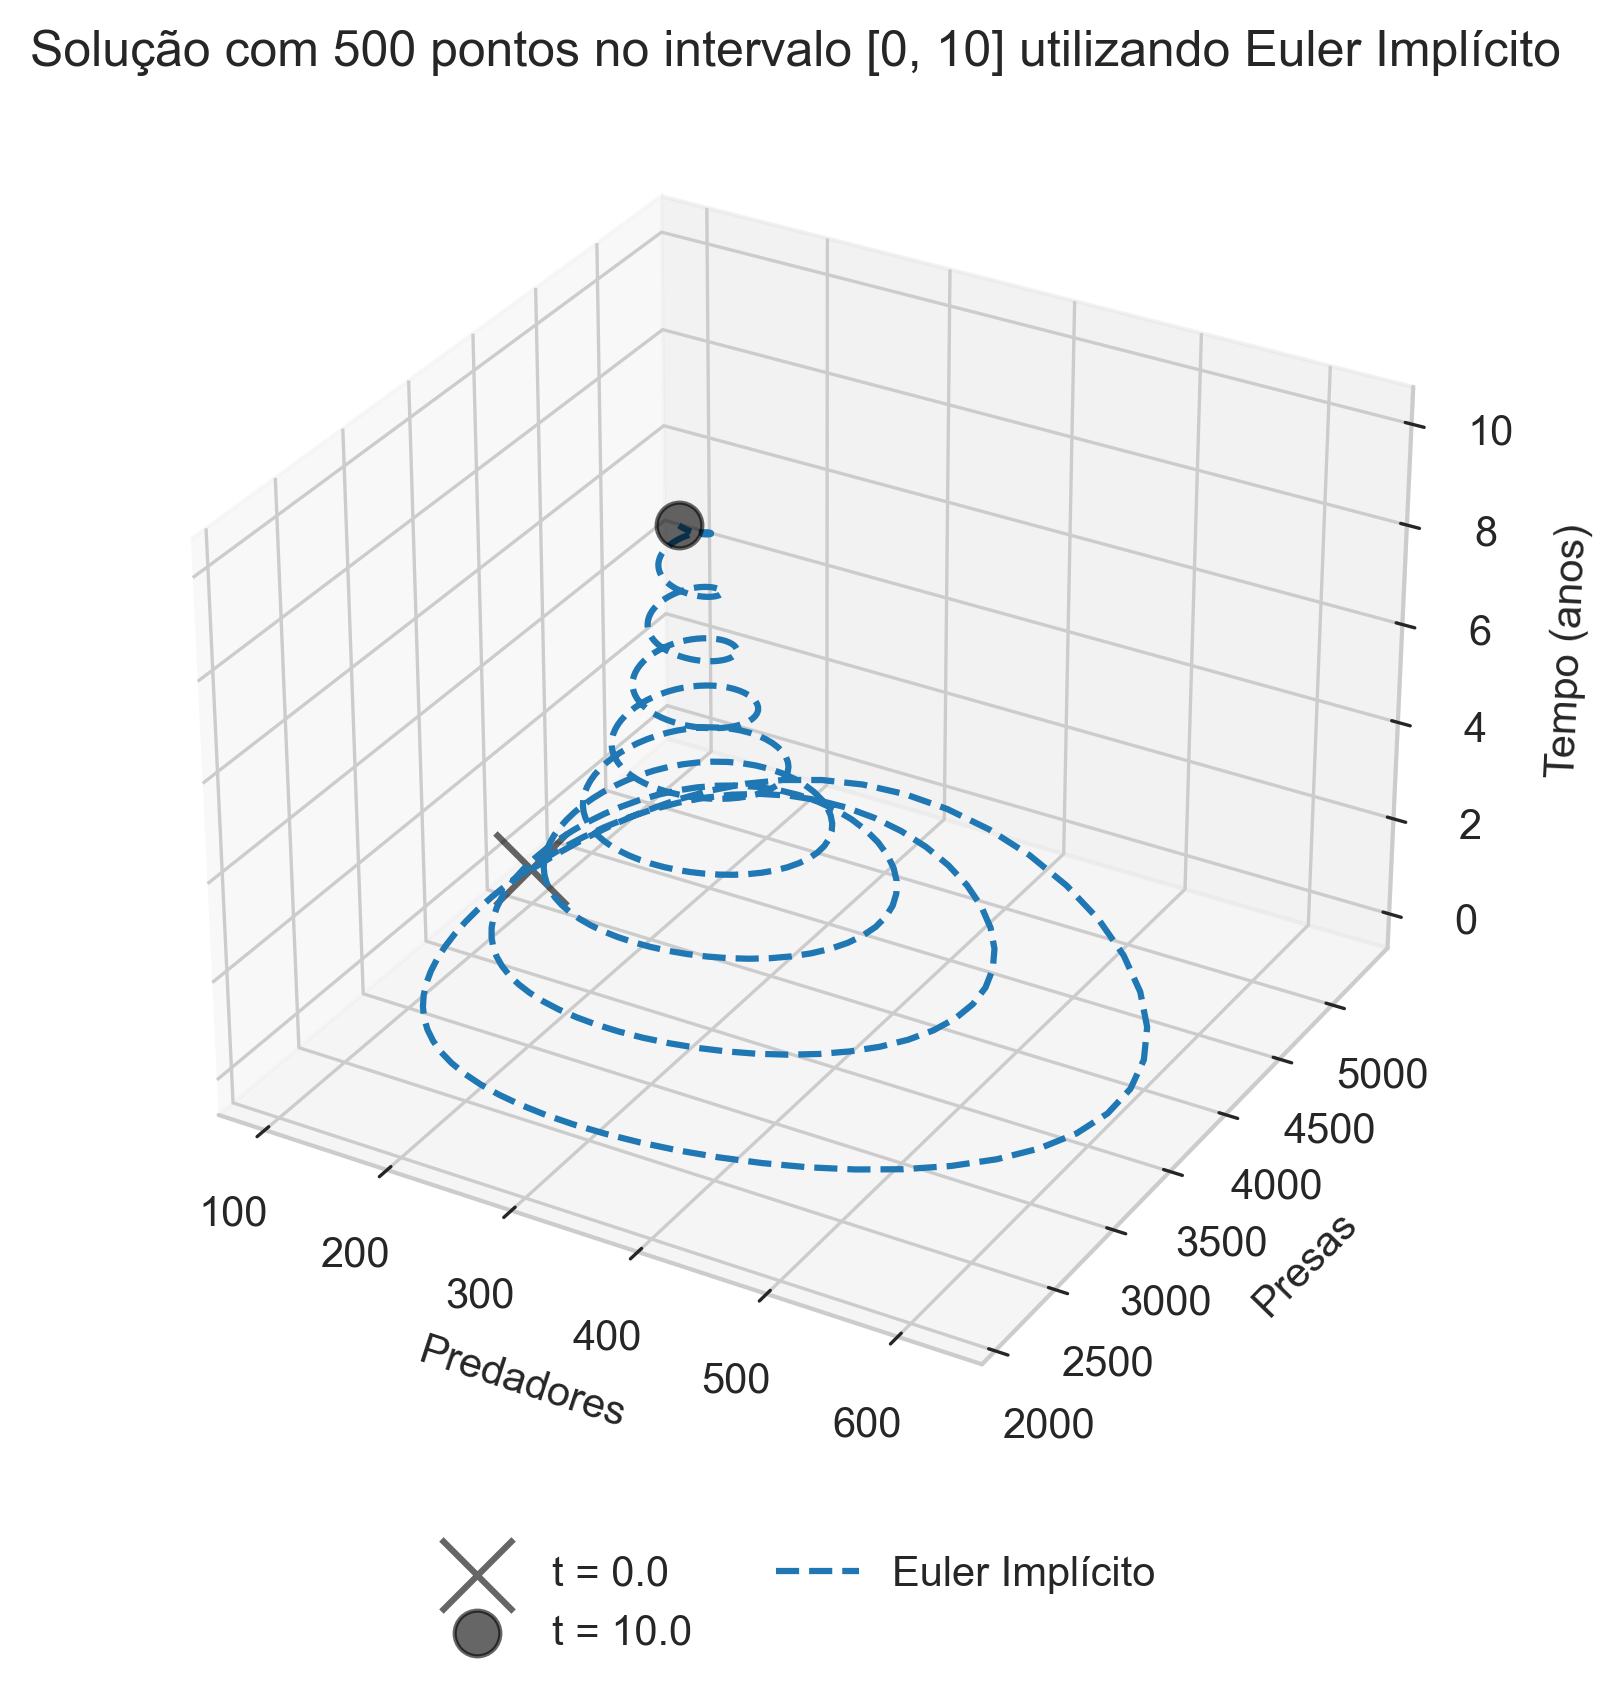

<Figure size 432x288 with 0 Axes>

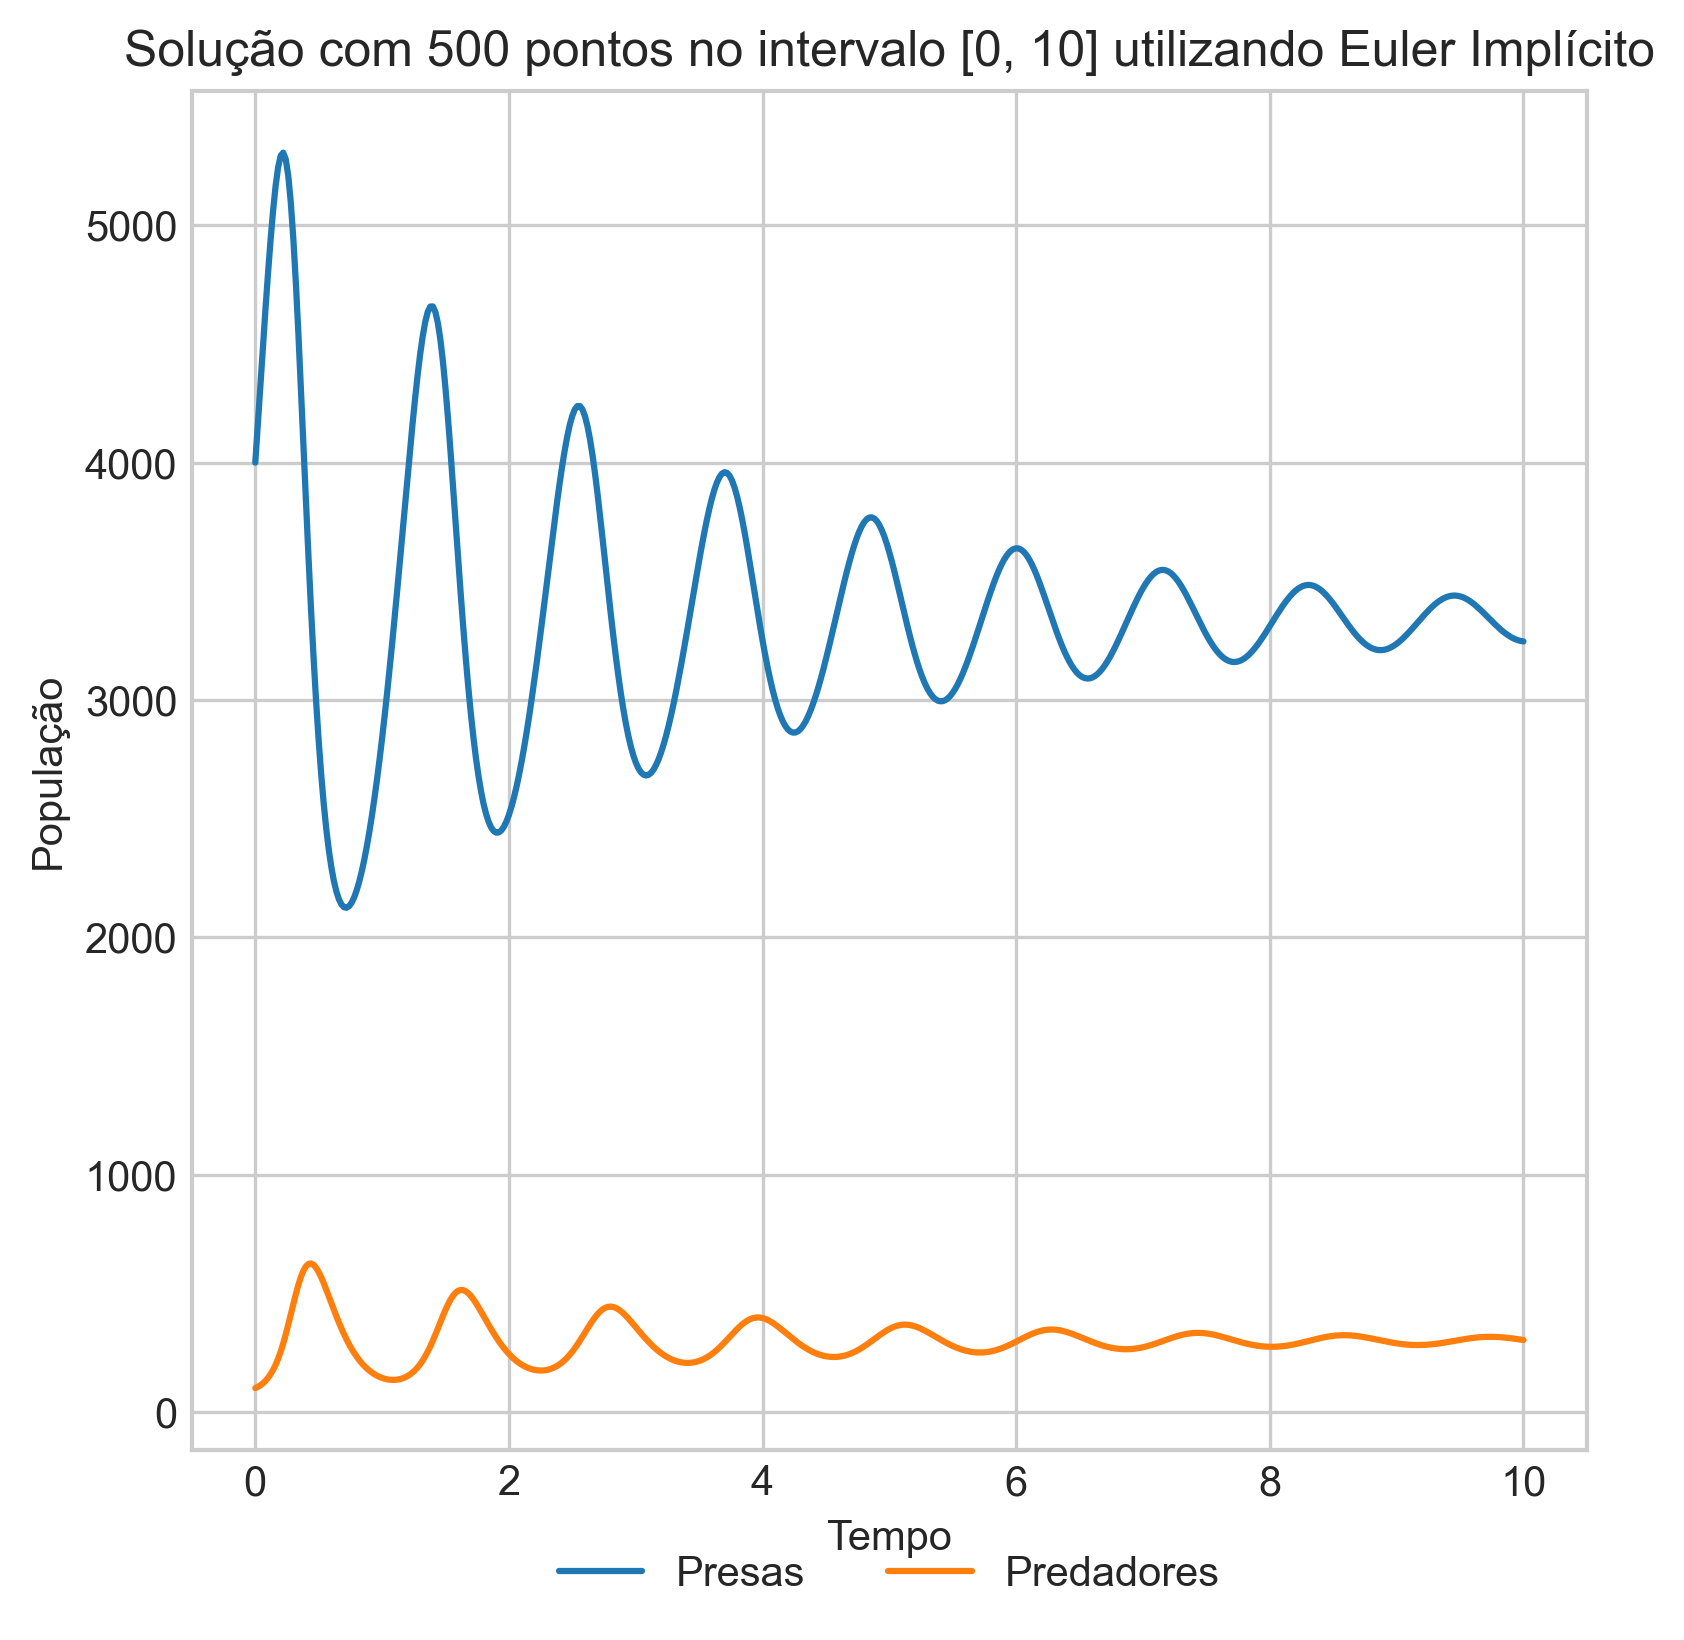

<Figure size 432x288 with 0 Axes>

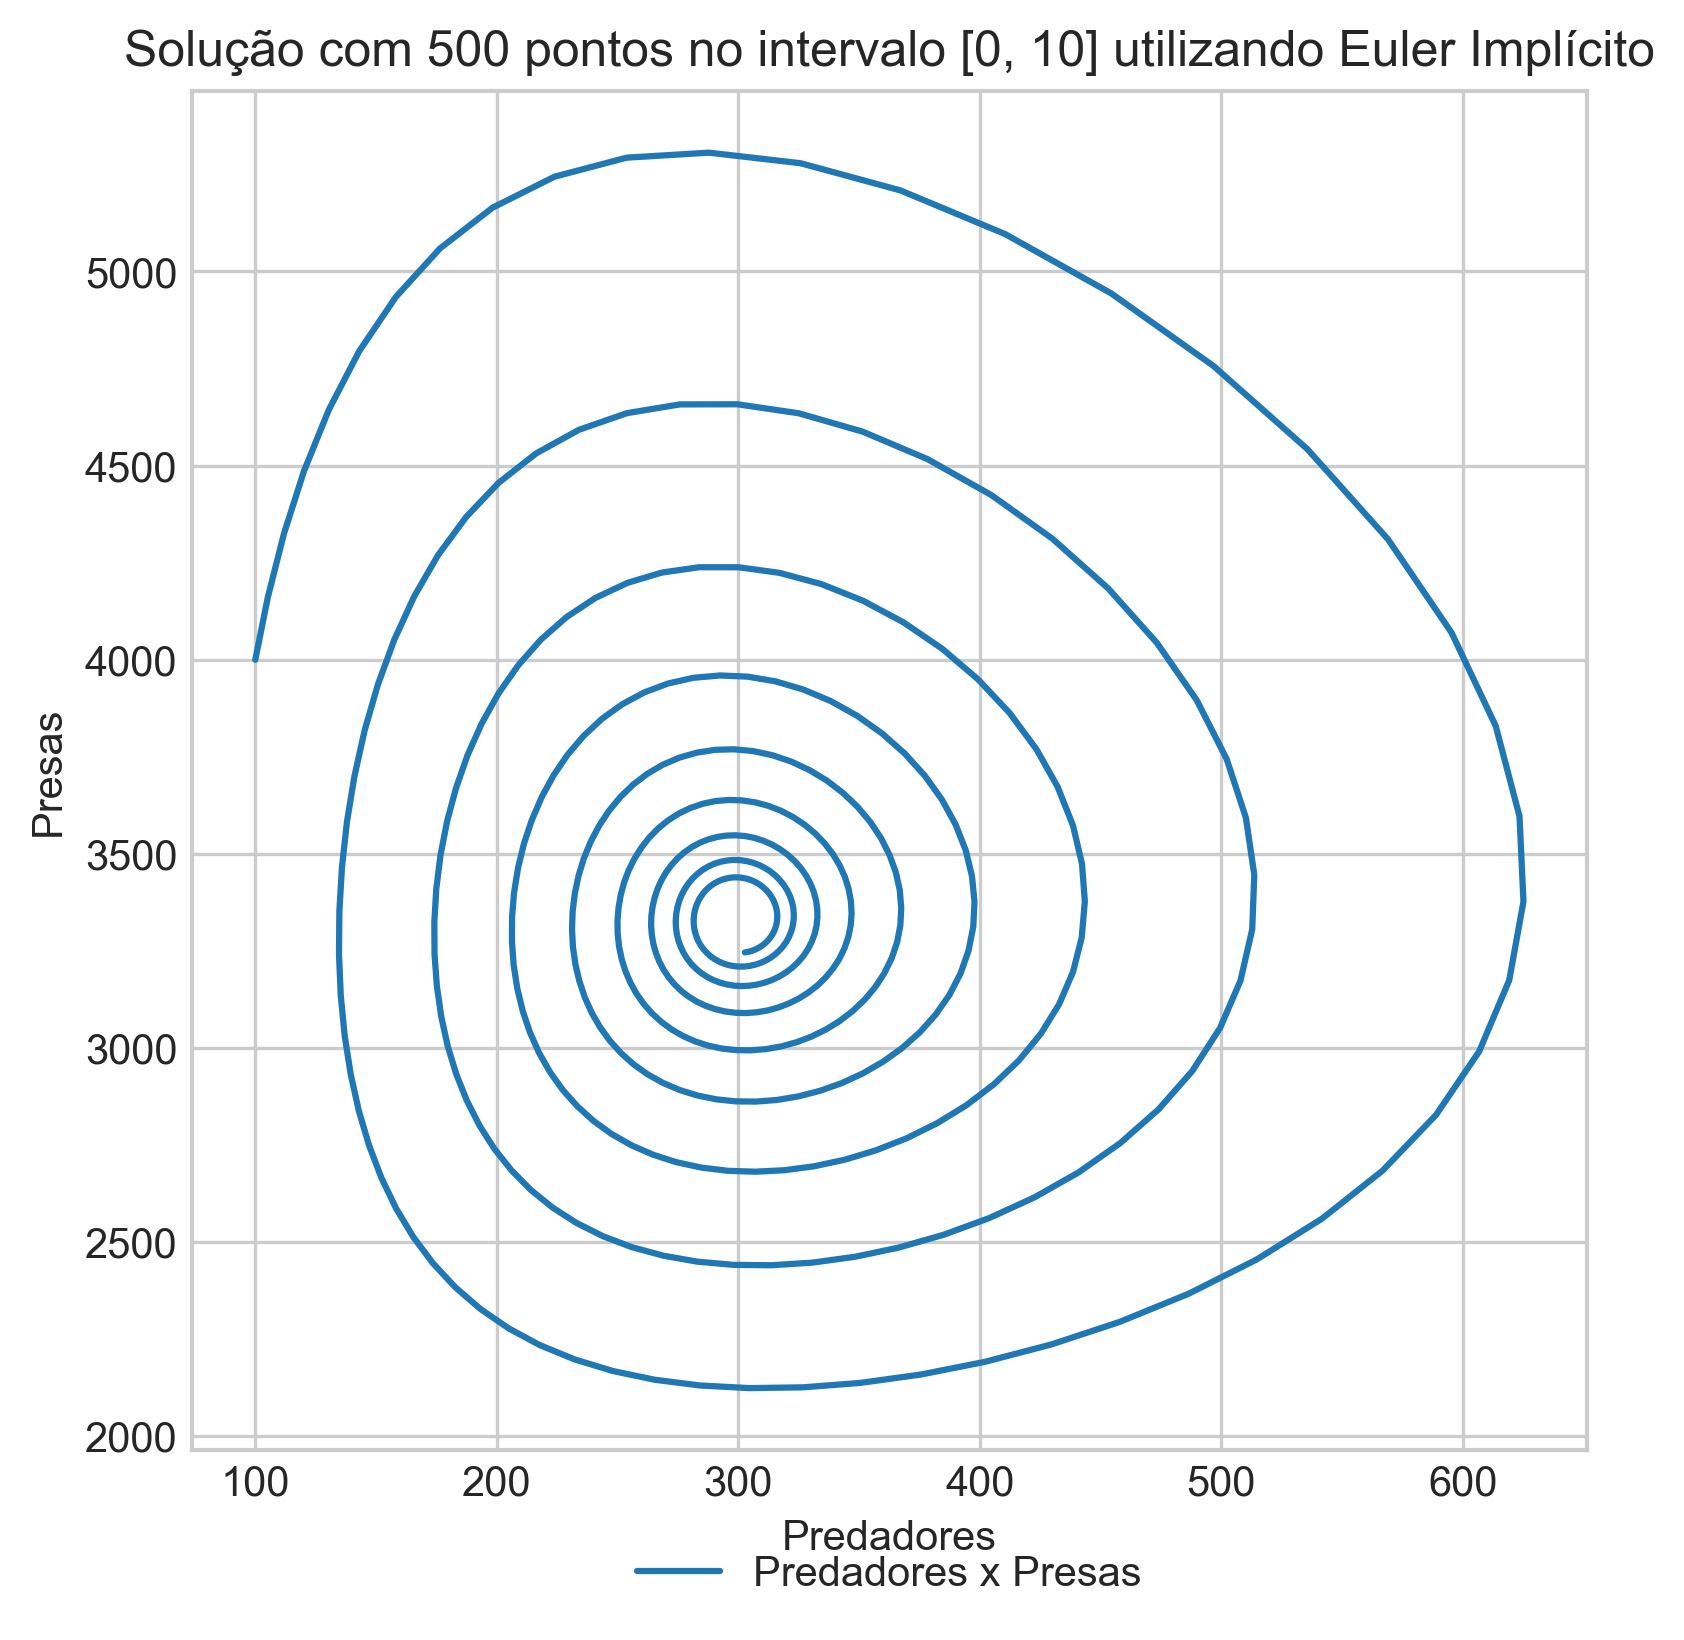

In [76]:
a, b = 0, 10
y0 = np.array([100, 4000])
n_steps = np.array([500])


rate_pred = 0.003
rate_prey = 3
prey_get_eaten = 1/100
starving = 10

@njit
def pred_prey(time, populations):
    pred, prey = populations[0], populations[1]
    d_pred = int(rate_pred * prey * pred) - int(starving * pred)
    d_prey = int(rate_prey * prey) - int(prey_get_eaten * prey * pred)
    return np.array([d_pred, d_prey])

methods = [
# "Euler Explícito",
"Euler Implícito",
# "Pto. Médio Mod.",
# "Runge-Kutta 3",
# "Runge-Kutta 4"
]
results = []
for it, n in enumerate(n_steps):

    for method in methods:
        t, P = fsolver(method, pred_prey, a, b, n, y0)
        result = PredatorPreyResult(time=t, predator=P[:, 0], prey=P[:, 1], method=method)
        results.append(result)


    ######################################################## 3D PLOT #########################
    ax = plt.figure(figsize=fsize, dpi=dpi).add_subplot(projection="3d")
    # change the angle of the camera view
    # ax.view_init(elev=20, azim=-45)
    ax.set_title(f"Solução com {n} pontos no intervalo [{a}, {b}] utilizando {method}")
    for result in results:
        pred, prey, time_ = result.predator, result.prey, result.time
        method = result.method
        # Plot the initial condition
        ax.scatter(pred[0], prey[0], time_[0], label=f"t = {time_[0]}", alpha=0.6, marker='x', s=300, c='black')
        # Plot the final condition as an arrow
        ax.scatter(pred[-1], prey[-1], time_[-1], label=f"t = {time_[-1]}", alpha=0.6, marker="o", s=120, c='black')
        ax.plot(pred, prey, time_, label=method, linestyle="dashed")

    ax.set_xlabel("Predadores")
    ax.set_ylabel("Presas")
    ax.set_zlabel("Tempo (anos)")
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
    plt.savefig(f"outputs/predator_prey-{dpi}dpi-{method.replace(' ', '_')}-{n} points.png")
    plt.show()

    ######################################################## 2D PLOT #########################
    plt.clf()
    plt.figure(figsize=fsize, dpi=dpi)
    plt.title(f"Solução com {n} pontos no intervalo [{a}, {b}] utilizando {method}")
    for result in results:
        pred, prey, time_ = result.predator, result.prey, result.time
        method = result.method
        plt.plot(time_, prey, label=f"Presas")
        plt.plot(time_, pred, label=f"Predadores")
        plt.xlabel("Tempo")
        plt.ylabel("População")
    # Legend on bottom center, with some pixels of padding from the bottom
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
    plt.savefig(f"outputs/predator_prey-{dpi}dpi-{method.replace(' ', '_')}-{n}points-2d.png")
    plt.show()
    ######################################################## 2D PLOT (UP) #########################
    plt.clf()
    plt.figure(figsize=fsize, dpi=dpi)
    plt.title(f"Solução com {n} pontos no intervalo [{a}, {b}] utilizando {method}")
    for result in results:
        pred, prey = result.predator, result.prey
        method = result.method
        plt.plot(pred, prey, label=f"Predadores x Presas")
        plt.xlabel("Predadores")
        plt.ylabel("Presas")
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
    plt.savefig(f"outputs/predator_prey-{dpi}dpi-{method.replace(' ', '_' )}-{n}points-2d-up.png")
    plt.show()


# Exemplo 1


In [77]:
# # k = 9.906e-4  # Coeficiente de decaimento

# # @njit
# # def dydx(t, x) -> np.ndarray:
# #     x_ = x[0]
# #     return np.array([k * x_ * (1000 - x_)])

# # # Integral of dydx


# @njit
# def y(t) -> np.ndarray:
#     if not isinstance(t, float):
#         results = np.zeros((t.shape[0], 1))
#         for i, t_ in enumerate(t):
#             results[i] = np.array([1000 / (1 + 999 * np.exp(-1000*k * t_))])
#         return results
#     else:
#         return np.array([1000 / (1 + 999 * np.exp(-1000*k * t))])
#     # sol = 1000 / (1 + 999 * np.exp(-1000 * k * t))


# # a = 0.0
# # b = 12.0
# # n = int(b - a)
# # n_arr = np.array([n * np.power(10, i) for i in range(0, 3)])
# # # y0 = np.array([y(a)])
# # y0 = y(a)

# # solver(dydx, a, b, n_arr, y0, ('Tempo (dias)', 'Infectados'), y)


In [78]:
# β = 1
# NMAX = 3000


# @njit
# def K(t):
#     return NMAX


# @njit
# def f(t, P):
#     P_ = P[0]
#     # Equação de carrying capacity (Lotka-Volterra)
#     return np.array([β * P_ * (1 - P_ / K(t))])


# a = 0
# b = 10
# n = b - a
# # n_arr = np.array([n * np.power(10, i) for i in range(0, 6, 2)])
# n_arr = np.array([n * np.power(10, i) for i in range(0, 3)])
# y0 = np.array([100])


# @njit
# def P(t):
#     if isinstance(t, float):
#         return np.array([K(t) / (((K(t) - y0[0]) / y0[0]) * np.exp(-β * t) + 1)])
#     else:
#         results = np.zeros((t.shape[0], 1))
#         for i, t_ in enumerate(t):
#             results[i] = np.array(
#                 [K(t_) /(1 + ((K(t_) - y0[0]) / y0[0]) * np.exp(-β * t_))])
#         return results


# solver(f, a, b, n_arr, y0, ('Tempo (anos)', 'População'), P)


In [79]:
a, b = 0, 10
y0 = np.array([100, 4000])
n_steps = np.array([500, 2500, 12500])

# dpi = 160

rate_pred = 0.003
rate_prey = 3
prey_get_eaten = 1/100
starving = 10

@njit(cache=True)
def pred_prey(time, populations):
    pred, prey = populations[0], populations[1]
    d_pred = int(rate_pred * prey * pred) - int(starving * pred)
    d_prey = int(rate_prey * prey) - int(prey_get_eaten * prey * pred)
    return np.array([d_pred, d_prey])

methods = [
# "Euler Explícito",
"Euler Implícito",
# "Pto. Médio Mod.",
# "Runge-Kutta 3",
"Runge-Kutta 4"
]
results = []
for method in methods:
        t, P = fsolver(method, pred_prey, a, b, n, y0)


In [80]:
for it, n in enumerate(n_steps):
    itera = 1
    for method in methods:
        start = time.perf_counter()
        for t_spent in range(itera):
            t, P = fsolver(method, pred_prey, a, b, n, y0)
        end = time.perf_counter()
        spent = (end - start) / itera
        result = PredatorPreyResult(time=t, predator=P[:, 0], prey=P[:, 1], method=method, time_spent=spent)
        results.append(result)


# Plotting

<Figure size 432x288 with 0 Axes>

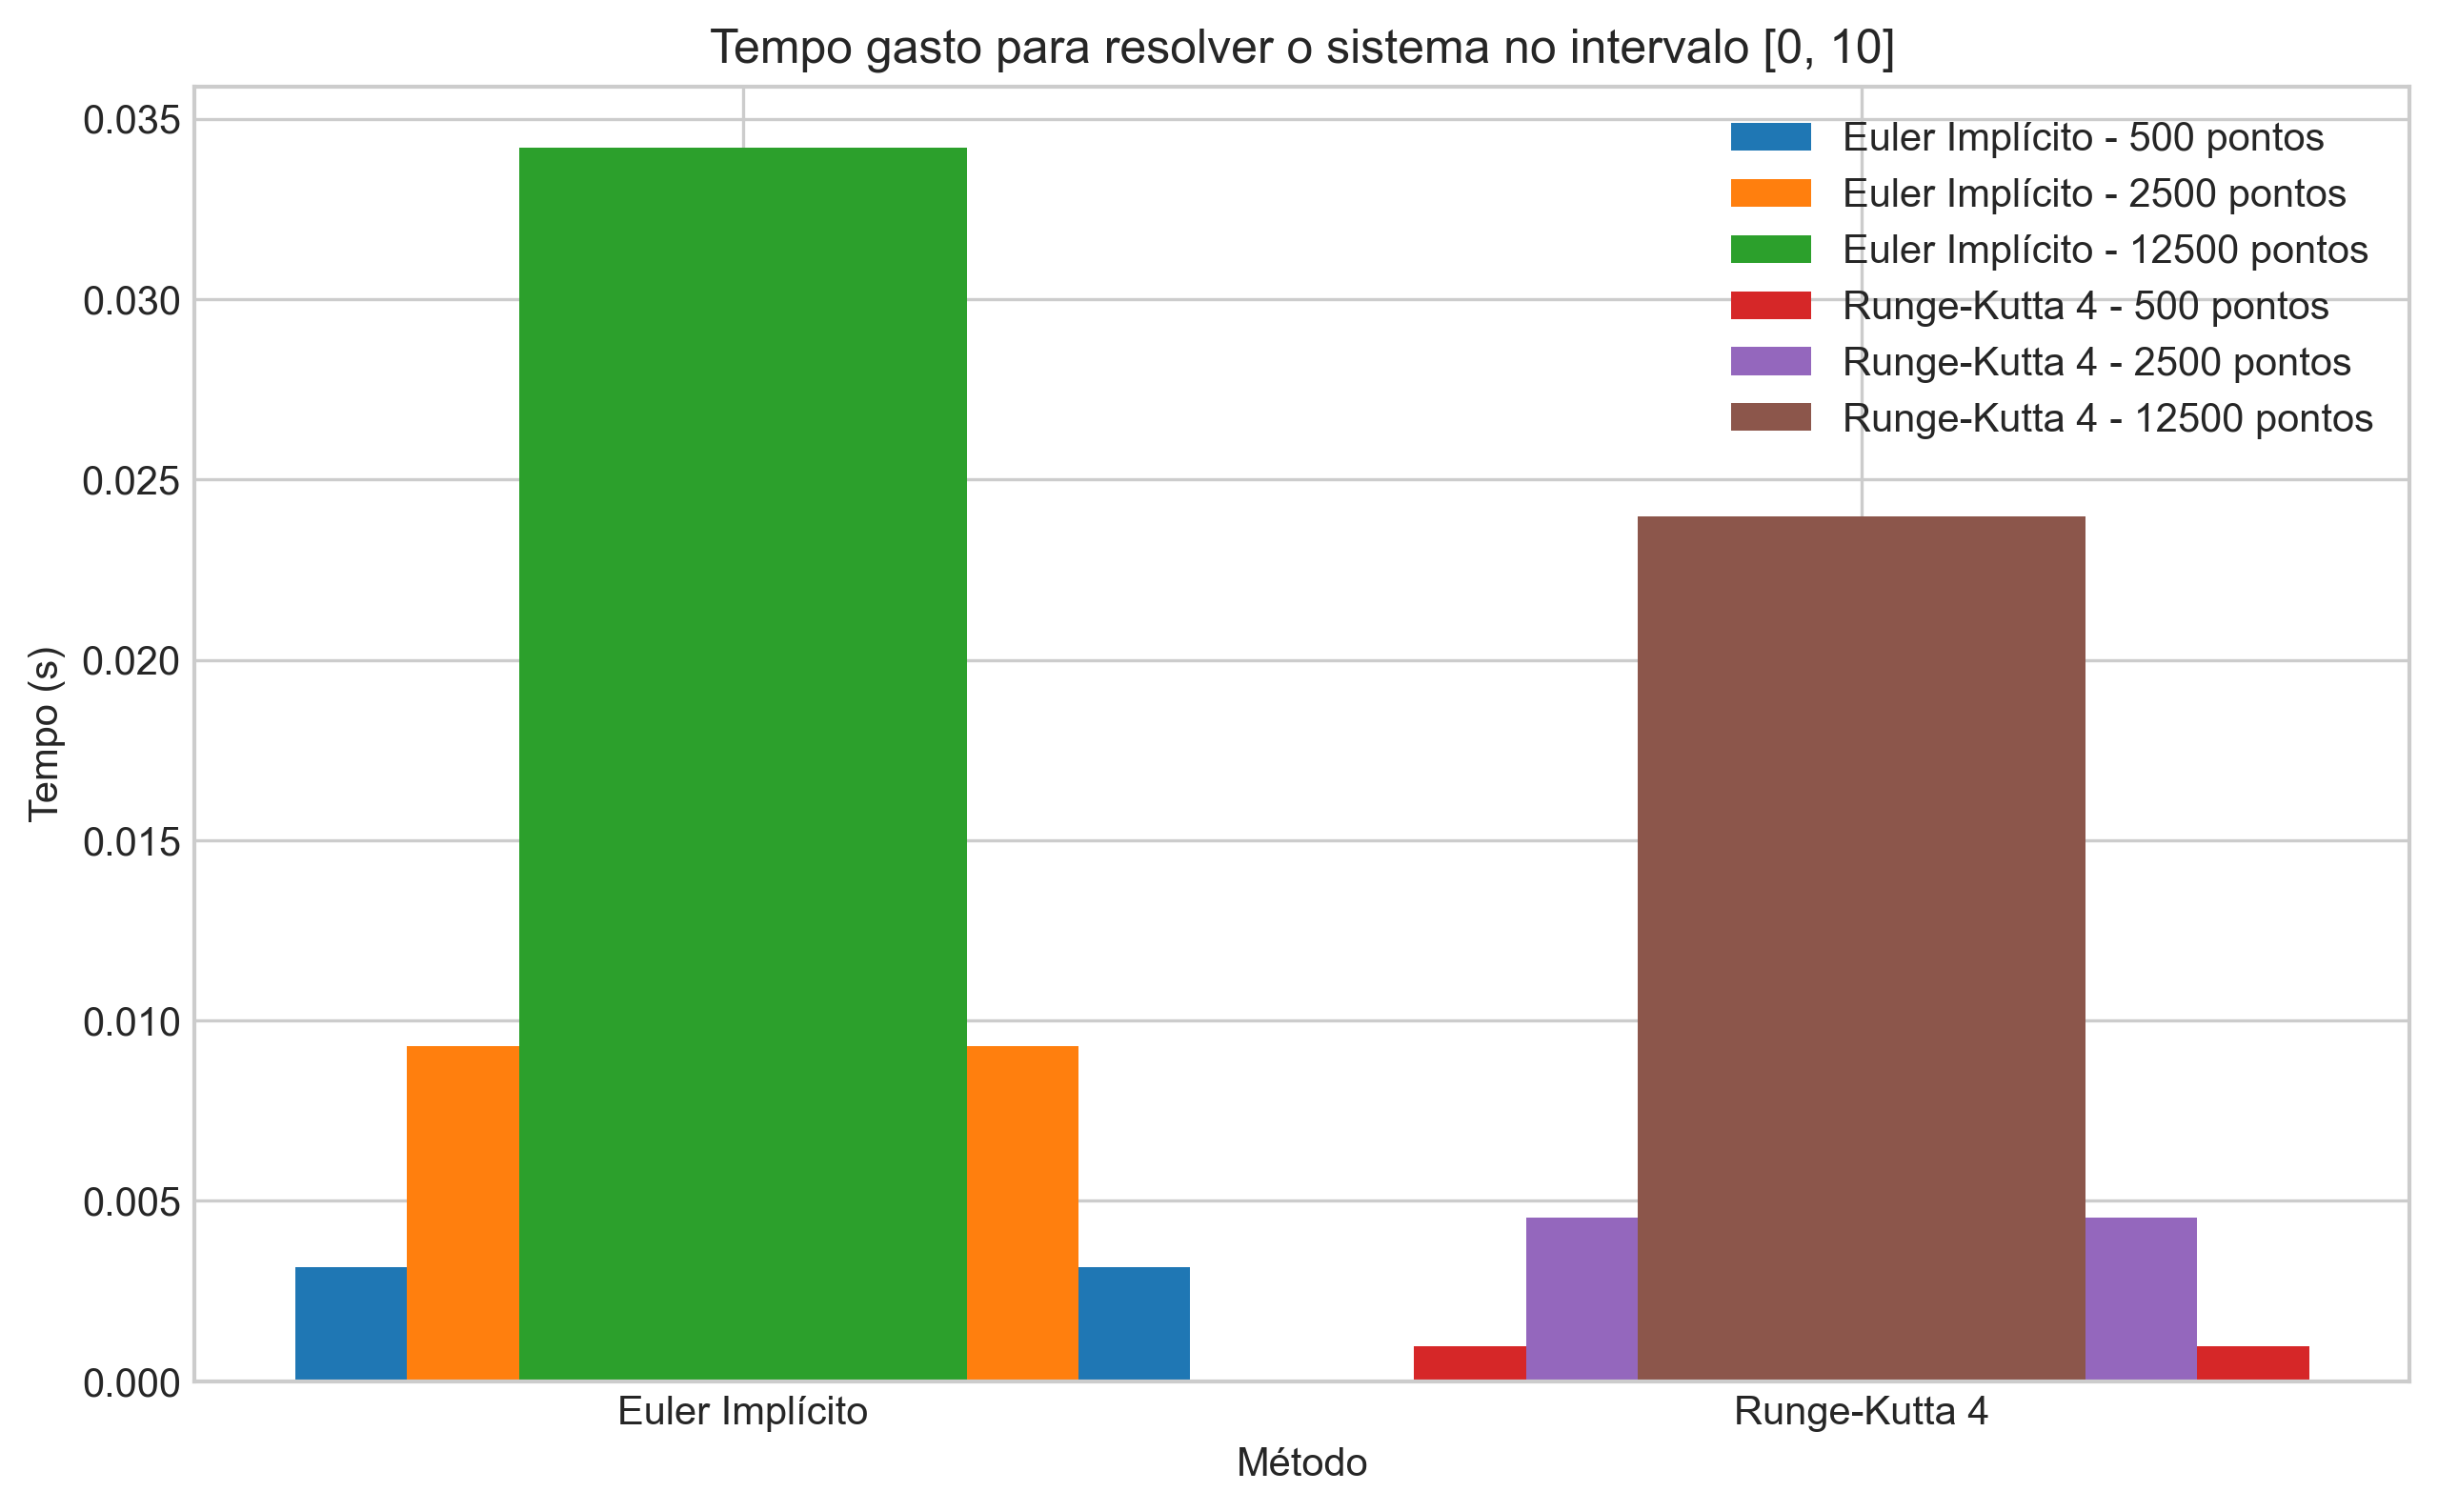

In [89]:
######################################################## 3D PLOT #########################
# ax = plt.figure(figsize=fsize, dpi=dpi).add_subplot(projection="3d")
# # change the angle of the camera view
# # ax.view_init(elev=20, azim=-45)
# ax.set_title(f"Comparação das soluções no intervalo [{a}, {b}]")
# for result in results:
#     pred, prey, time_ = result.predator, result.prey, result.time
#     method = result.method
#     n = len(time_) - 1
#     # Plot the initial condition
#     ax.plot(pred, prey, time_, linestyle="dashed", label=f"{method} - {n} pontos")
# ax.scatter(pred[0], prey[0], time_[0], label=f"t = {time_[0]}", alpha=1, marker='x', s=300, c='black')

# ax.set_xlabel("Predadores")
# ax.set_ylabel("Presas")
# ax.set_zlabel("Tempo (anos)")
# plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
# plt.savefig(f"outputs/predator_prey-{dpi}dpi-{method.replace(' ', '_')}-{n} points.png")
# plt.show()

# ######################################################## 2D PLOT #########################
# plt.clf()
# plt.figure(figsize=fsize, dpi=dpi)
# plt.title(f"Solução com {n} pontos no intervalo [{a}, {b}] utilizando {method}")
# for result in results:
#     pred, prey, time_ = result.predator, result.prey, result.time
#     method = result.method
#     plt.plot(time_, prey, label=f"Presas")
#     plt.plot(time_, pred, label=f"Predadores")
#     plt.xlabel("Tempo")
#     plt.ylabel("População")
# # Legend on bottom center, with some pixels of padding from the bottom
# plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
# plt.savefig(f"outputs/predator_prey-{dpi}dpi-{method.replace(' ', '_')}-{n}points-2d.png")
# plt.show()
# ######################################################## 2D PLOT (UP) #########################
# plt.clf()
# plt.figure(figsize=fsize, dpi=dpi)
# plt.title(f"Comparação das soluções no intervalo [{a}, {b}]")
# for result in results:
#     pred, prey = result.predator, result.prey
#     method = result.method
#     n = len(pred) - 1
#     if method == "Runge-Kutta 4":
#         plt.plot(pred, prey, label=f"Predadores x Presas - {method} - {n} pontos", linestyle=(0, (3, 10, 1, 10, 1, 10)), linewidth=0.95)
#     else:
#         plt.plot(pred, prey, label=f"Predadores x Presas - {method} - {n} pontos", linestyle="dashed", linewidth=0.95)
#     plt.xlabel("Predadores")
#     plt.ylabel("Presas")
# plt.scatter(pred[0], prey[0], label=f"t = {time_[0]}", alpha=1, marker='x', s=300, c='black')
# plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
# plt.savefig(f"outputs/predator_prey-{dpi}dpi-{method.replace(' ', '_' )}-{n}points-2d-up.png")
# plt.show()


# Plot the time spent
plt.clf()
plt.figure(figsize=fsize, dpi=dpi)
plt.title(f"Tempo gasto para resolver o sistema no intervalo [{a}, {b}]")
for result in results:
    method = result.method
    time_spent = result.time_spent
    n = len(result.predator) - 1
    if method == "Euler Implícito":
        if n == 500:
            plt.bar(method, time_spent, label=f"{method} - {n} pontos", width=0.8)
        elif n == 2500:
            plt.bar(method, time_spent, label=f"{method} - {n} pontos", width=0.6)
        else:
            plt.bar(method, time_spent, label=f"{method} - {n} pontos", width=0.4)

for result in results:
    method = result.method
    time_spent = result.time_spent
    n = len(result.predator) - 1
    if method == "Runge-Kutta 4":
        if n == 500:
            plt.bar(method, time_spent, label=f"{method} - {n} pontos", width=0.8)
        elif n == 2500:
            plt.bar(method, time_spent, label=f"{method} - {n} pontos", width=0.6)
        else:
            plt.bar(method, time_spent, label=f"{method} - {n} pontos", width=0.4)


plt.xlabel("Método")
plt.ylabel("Tempo (s)")
plt.legend()
# plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.savefig(f"outputs/predator_prey-{dpi}dpi-time-comparison-{n}points-time.png")
plt.show()

